In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
ir = pd.read_excel('офз.xlsx', index_col=0, header=1) / 100/365

In [3]:
pca = PCA()
first_comp = pca.fit_transform(ir)[:,0]

__Vasicek Model:__ $dr_t = \alpha(b-r_t)dt + \sigma dW_t$   
Точное решение: $r_t \sim N\left(r_0 e^{-\alpha t} + b (1-e^{-\alpha t}),\,\tfrac{\sigma^2}{2\alpha}\left(1-e^{-2\alpha t}\right)\right)
$

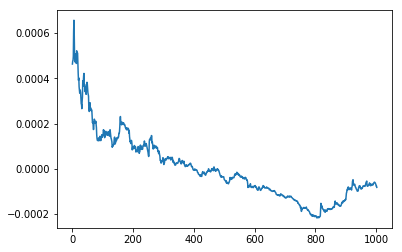

In [4]:
plt.plot(first_comp[np.arange(len(first_comp)-1, 0, step=-1)])

In [5]:
def minimizeNLogLikelihood(r, dates, lastDate):
    dt = 1 #T / N
    rt = r[dates < lastDate]
    N = r.shape[0]
    params0 = np.array([0.0000001,0.0000001,0.0000001])
    
    def VasicekLogLikelihood(params):
        alpha, b, sigma = params[0], params[1], params[2] 
        return -(N-1)*np.log(alpha/(sigma**2*(1-np.exp(-2*alpha*dt)))) \
            - alpha/(sigma**2*(1-np.exp(-2*alpha*dt)))*np.sum(-(rt[:-1] - rt[1:]*np.exp(-alpha*dt)-b*(1-np.exp(-alpha*dt)))**2) 
    
    params_opt = minimize(VasicekLogLikelihood, params0, method='Powell')
    return params_opt.x

In [15]:
dates = np.array(['-'.join(x.split('.')[::-1]) for x in ir.index[::-1]]).astype('M8[D]')

In [16]:
def closest_date(day, dates = dates):
    return dates[dates <= day][-1]
    

In [26]:
bond_i = 4
coupons4 =pd.read_excel('офз_график_выплат.xlsx', bond_i)[['Date', 'Coupon']].astype({'Date':'M8[D]'})

coupons_date = coupons4['Date'].values


info = pd.read_excel('офз_описание.xlsx',bond_i, index_col=0)

coupon_rate = np.mean(info.loc['Сумма купона, в валюте номинала'])
coupon_rate = coupons4['Coupon'].values/2/100

expDate = np.datetime64(info.loc['Дата погашения'].values[0])
forDate = closest_date(np.datetime64('2018-12-03')-1)

print('for date', forDate+1)
print('expDate', expDate)
print('coupon', coupon_rate)

face = info.loc['Номинальная стоимость'].values[0]

for date 2018-12-01
expDate 2020-05-27T00:00:00.000000
coupon [0.032 0.032 0.032 0.032 0.032 0.032 0.032 0.032 0.032 0.032 0.032 0.032
 0.032 0.032]


In [27]:
logr = np.log(first_comp - min(first_comp) + 0.000000001)
r0 = logr[dates <= forDate][0]

In [28]:
params = minimizeNLogLikelihood(logr, dates, forDate)
params

array([ 0.05767098, -8.81095251,  0.23514524])

In [29]:
def VasicekPath(T,params,r0):
    dt = 1 #T/M
    
    alpha, b, sigma = params[0], params[1], params[2]
    t = np.arange(T) #np.linspace(0,T,M)
    r = np.zeros(T)
    B = np.zeros(T)
    B[0] = 1
    r[0] = r0
    #r[0] = np.log(r0)
    
    for i in range(1,T):
        r[i] = r[i-1] + alpha*(b-r[i-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
#     for i in range(1,T):
#         B[i] = np.prod([1+np.exp(x) for x in r[i:]])
    return (r, B, t)

In [30]:
def PriceBond(params, r0, forDate, coupons_date, couponRate, N, FaseValue=face):
    TimetoMaturity = np.apply_along_axis(lambda x: int((x - forDate)/ np.timedelta64(1,'D')), 1, coupons_date)
    res = np.zeros((N, TimetoMaturity[-1]))
    discount_factor = np.zeros((N, TimetoMaturity[-1]))
    for i in tqdm(range(N)):
        (r,B,t) = VasicekPath(TimetoMaturity[-1], params, r0)

        #считаем значение показатель дисконтирования
        #d = np.cumproduct((1+np.exp(r))[::-1])[::-1]
        d = 1/np.exp(np.cumsum(-np.exp(r[::-1])))[::-1]
        discount_factor[i] = d
        
        
        #для каждого купона считаем его динамику цены 
        #(делим значение купона на показатель дисконтирования)
        for c, j in enumerate(TimetoMaturity):
  
            
            V = FaseValue*couponRate[c] if j != len(B) else FaseValue*(1+couponRate[c])
            B = np.zeros(len(r))
            
            B[:j] = V / d[:j]            

            res[i] += B
    return res, r, B, TimetoMaturity, discount_factor

In [31]:
p,r,B,TtM, descount_factor = PriceBond(params, r0, forDate,
                                       coupons_date[coupons_date > forDate].reshape(-1, 1),
                                       coupon_rate[coupons_date > forDate], 1000)


Text(0.5,1,'mean discount factor')

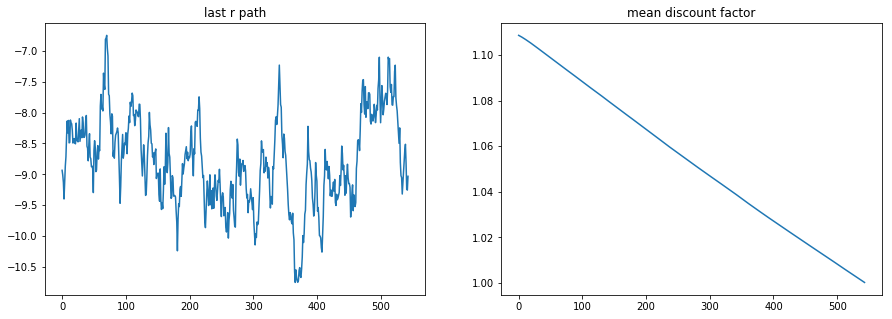

In [32]:
plt.figure(figsize =(15,5))

plt.subplot(121)
plt.plot(r)
plt.title('last r path')

plt.subplot(122)
plt.plot(descount_factor.mean(0))
plt.title('mean discount factor')

In [33]:
bond_price = pd.read_excel('офз_данные.xlsx', bond_i, index_col=2).iloc[:, 6:7]
bond_price.columns=['price']

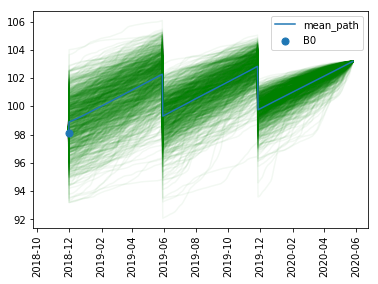

In [35]:
last_point = 3000

dates_index = pd.date_range(forDate, expDate)[:-1]
plt.scatter(forDate, bond_price.loc[forDate]['price'], label='B0', s=50, zorder=10)

plt.plot(dates_index[:last_point], [bond_price.loc[forDate]['price']] + list(p.mean(0)[1:last_point]/10), label='mean_path', zorder=10)


for i in p:
    plt.plot(dates_index[:last_point], [bond_price.loc[forDate]['price']] + list(i[1:last_point]/10), c='g', alpha=0.05)
    

plt.legend()
plt.xticks(rotation=90);
#plt.xlim((forDate-1, dates_index[:last_point][-1]+1));

#plt.plot(p1.loc[forDate:]['price'])


### Посмотрим на распределение доходности на 3 декабря 

In [48]:
p_path = pd.DataFrame(p, columns=dates_index)/10

p0 = bond_price.loc[forDate].values[0]
p1_pred = p_path[forDate+1].values


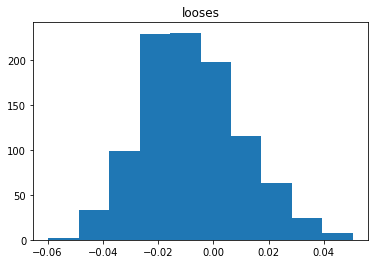

In [50]:
looses = (p0-p1_pred)/p0
plt.hist(looses);
plt.title(f"looses");

In [52]:
alpha=0.95
VaR = np.percentile(looses, alpha*100)
print(f"VaR = {VaR*100:.2f}%")

VaR = 2.46%


In [53]:
p1 = bond_price.loc[forDate:]['price'][1]
los_real = (p0-p1)/p0*100
print(f"Real loss on {forDate+1} = {los_real:.2f}%")

Real loss on 2018-12-01 = -0.10%
